# Автоэнкодеры в Keras

# Часть 4: Conditional VAE

### Содержание

* Часть 1: Введение
* Часть 2: *Manifold learning* и скрытые (*latent*) переменные
* Часть 3: Вариационные автоэнкодеры (*VAE*)
* ** Часть 4: *Conditional VAE* **
* Часть 5: *GAN* (Generative Adversarial Networks) и tensorflow
* Часть 6: *VAE* + *GAN*



В прошлой части мы познакомились с ***вариационными автоэнкодерами (VAE)***, реализовали такой на *keras*, а так же поняли, как с его помощью генерировать изображения. Получившаяся модель, однако, обладала некоторыми недостатками:
1. Не все цифры получилось хорошо закодировать в скрытом пространстве: некоторые цифры либо, вообще остсутствовали, либо были очень смазанными. В промежутках между областями, в которых были сконцентрированы варианты одной и той же цифры, находились вообще какие-то быссмысленные иероглифы.  
    Что тут писать, вот так выглядели сгенерированные цифры:
<img src="./figs4/manifold_vae.png" width="400"/>
2. Сложно было генерировать картинку какой-то заданной цифры. Для этого надо было смотреть, в какую область латентного пространства попадали изображения конкретной цифры, и сэмплить уже откуда-то оттуда, а тем более было сложно генерировать цифру в каком-то заданном стиле.

В этой части мы посмотрим как можно лишь очень слегка усложнив модель преодолеть обе эти проблемы, и заодно получим возможность генерировать картинки новых цифр в стиле другой цифры - это наверное самая интересная фича будущей модели. 

### Сначала подумаем о причинах 1-го недостатка:  
Многообразия на которых лежат различные цифры могут быть далеко друг от друга в пространстве картинок. То есть сложно представить, как например непрерывно отобразить картинку цифры '5', в картинку цифры '7', при том, чтобы все промежуточные картинки можно было назвать правдоподобными. Таким образом, многообразие, около которого лежат цифры, вовсе не обязано быть линейно связным. Автоэнкодер же, в силу того что является композицией непрерывных функций, сам может отображать в код и обратно только непрерывно, особенно если это вариационный автоэнкодер. В нашем предыдущем примере все усложнялось еще и тем, что, автоэнкодер пытался искать двумерное многообразие.  
В качестве иллюстрации вернемся к нашему искусственному примеру из 2-ой части, только сделаем определяющее многообразие несвязным:
<img src="./figs4/disconnected_manifold.png" width="600"/>

Здесь:
* синие и зеленые точки - объекты выборки,
* красная и желтая кривые - несвязанное определяющее многообразие.

Попробуем теперь выучить определяющее многообразие с помощью обычного глубокого автоэнкодера.  
Код: (скрыто)

Using TensorFlow backend.


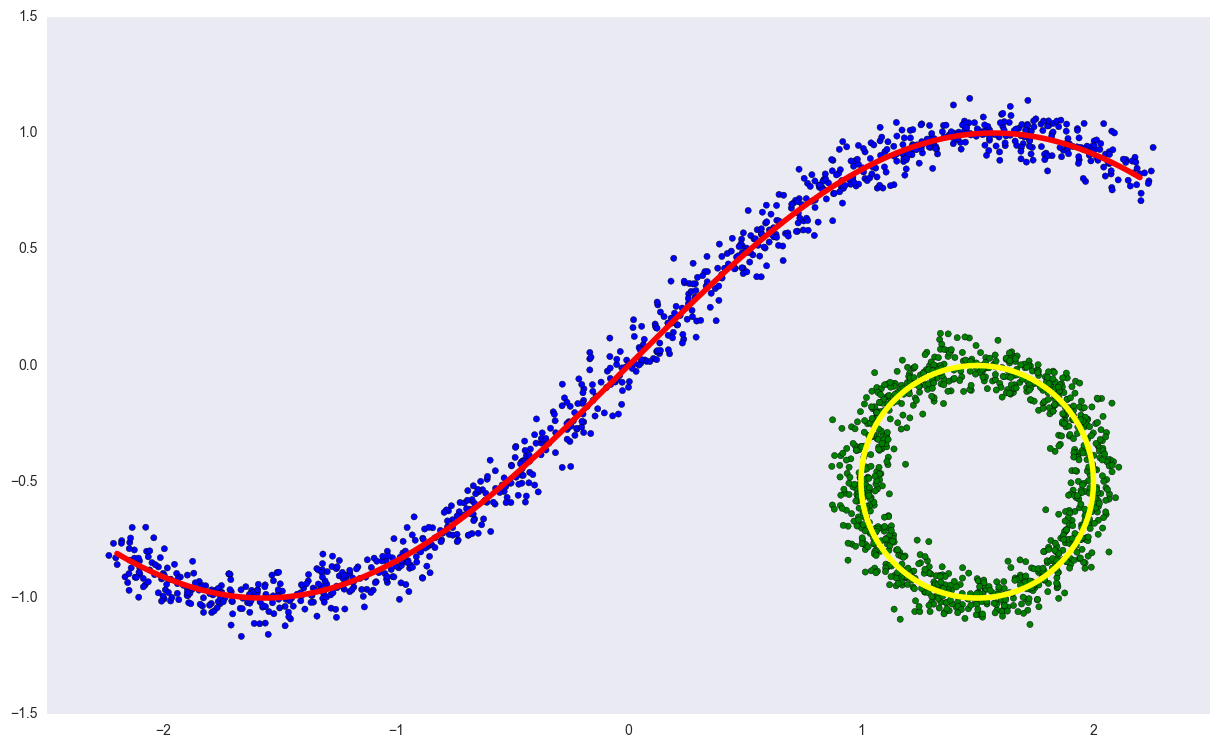

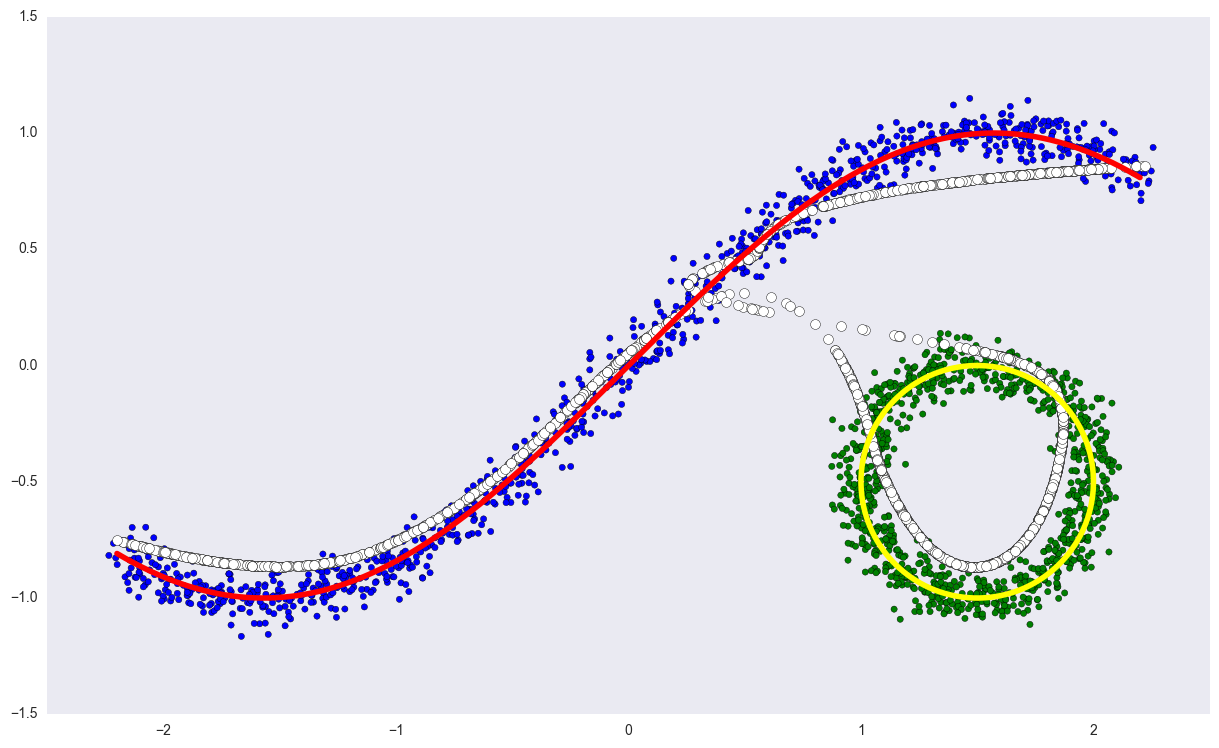

In [1]:
# Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Создание датасета
x1 = np.linspace(-2.2, 2.2, 1000)
fx = np.sin(x1)
dots1 = np.vstack([x1, fx]).T

t = np.linspace(0, 2*np.pi, num=1000)
dots2 = 0.5*np.array([np.sin(t), np.cos(t)]).T + np.array([1.5, -0.5])[None, :]

dots = np.vstack([dots1, dots2])
noise = 0.06 * np.random.randn(*dots.shape)

labels = np.array([0]*1000 + [1]*1000)
noised = dots + noise


# Визуализация
colors = ['b']*1000 + ['g']*1000
plt.figure(figsize=(15, 9))
plt.xlim([-2.5, 2.5])
plt.ylim([-1.5, 1.5])
plt.scatter(noised[:, 0], noised[:, 1], c=colors)
plt.plot(dots1[:, 0], dots1[:, 1],  color="red",    linewidth=4)
plt.plot(dots2[:, 0], dots2[:, 1],  color="yellow", linewidth=4)
plt.grid(False)

# Модель и обучение
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam

def deep_ae():
    input_dots = Input((2,))
    x = Dense(64, activation='elu')(input_dots)
    x = Dense(64, activation='elu')(x)
    code = Dense(1, activation='linear')(x)
    x = Dense(64, activation='elu')(code)
    x = Dense(64, activation='elu')(x)
    out = Dense(2, activation='linear')(x)

    ae = Model(input_dots, out)
    return ae

dae = deep_ae()
dae.compile(Adam(0.001), 'mse')
dae.fit(noised, noised, epochs=300, batch_size=30, verbose=2)

# Результат
predicted = dae.predict(noised)

# Визуализация
plt.figure(figsize=(15, 9))
plt.xlim([-2.5, 2.5])
plt.ylim([-1.5, 1.5])
plt.scatter(noised[:, 0], noised[:, 1], c=colors)
plt.plot(dots1[:, 0], dots1[:, 1],  color="red",    linewidth=4)
plt.plot(dots2[:, 0], dots2[:, 1],  color="yellow", linewidth=4)
plt.scatter(predicted[:, 0], predicted[:, 1], c='white', s=50)
plt.grid(False)

<img src="./figs4/disconnected_manifold_dae.png" width="600"/>

* белая линия - многообразие в которое переходят синие и зеленые точки данных после автоэнкодера,
то есть попытка автоэнкодера построить многообразие, определяющее больше всего вариации в данных

Видно, что у простого автоэнкодера не получилось выучить форму несвязного многообразия. Вместо этого, он хитро продолжил одно в другое.

Если же мы знаем лейблы данных, которые определяют на каком из частей несвязного многообразия лежат данные (как с цифрами), то мы можем просто *condition* автоэнкодер на этих лейблах. То есть просто дополнительно с данными, подавать на вход энкодеру и декодеру еще и лейблы данных. В таком случае источником разрывности в данных будет лейбл и это позволит автоэнкодеру выучить каждую часть линейно несвязного многообразия отдельно.

Посмотрим на тот же самый пример, только теперь на вход и энкодеру, и декодеру будем передавать дополнительно еще и лейбл.

Код (скрыто):

Epoch 1/300
0s - loss: 0.1679
Epoch 2/300
0s - loss: 0.0460
Epoch 3/300
0s - loss: 0.0438
Epoch 4/300
0s - loss: 0.0436
Epoch 5/300
0s - loss: 0.0422
Epoch 6/300
0s - loss: 0.0419
Epoch 7/300
0s - loss: 0.0420
Epoch 8/300
0s - loss: 0.0418
Epoch 9/300
0s - loss: 0.0420
Epoch 10/300
0s - loss: 0.0416
Epoch 11/300
0s - loss: 0.0423
Epoch 12/300
0s - loss: 0.0415
Epoch 13/300
0s - loss: 0.0418
Epoch 14/300
0s - loss: 0.0415
Epoch 15/300
0s - loss: 0.0412
Epoch 16/300
0s - loss: 0.0409
Epoch 17/300
0s - loss: 0.0412
Epoch 18/300
0s - loss: 0.0404
Epoch 19/300
0s - loss: 0.0407
Epoch 20/300
0s - loss: 0.0405
Epoch 21/300
0s - loss: 0.0403
Epoch 22/300
0s - loss: 0.0401
Epoch 23/300
0s - loss: 0.0398
Epoch 24/300
0s - loss: 0.0396
Epoch 25/300
0s - loss: 0.0381
Epoch 26/300
0s - loss: 0.0378
Epoch 27/300
0s - loss: 0.0371
Epoch 28/300
0s - loss: 0.0365
Epoch 29/300
0s - loss: 0.0356
Epoch 30/300
0s - loss: 0.0359
Epoch 31/300
0s - loss: 0.0364
Epoch 32/300
0s - loss: 0.0354
Epoch 33/300
0s -

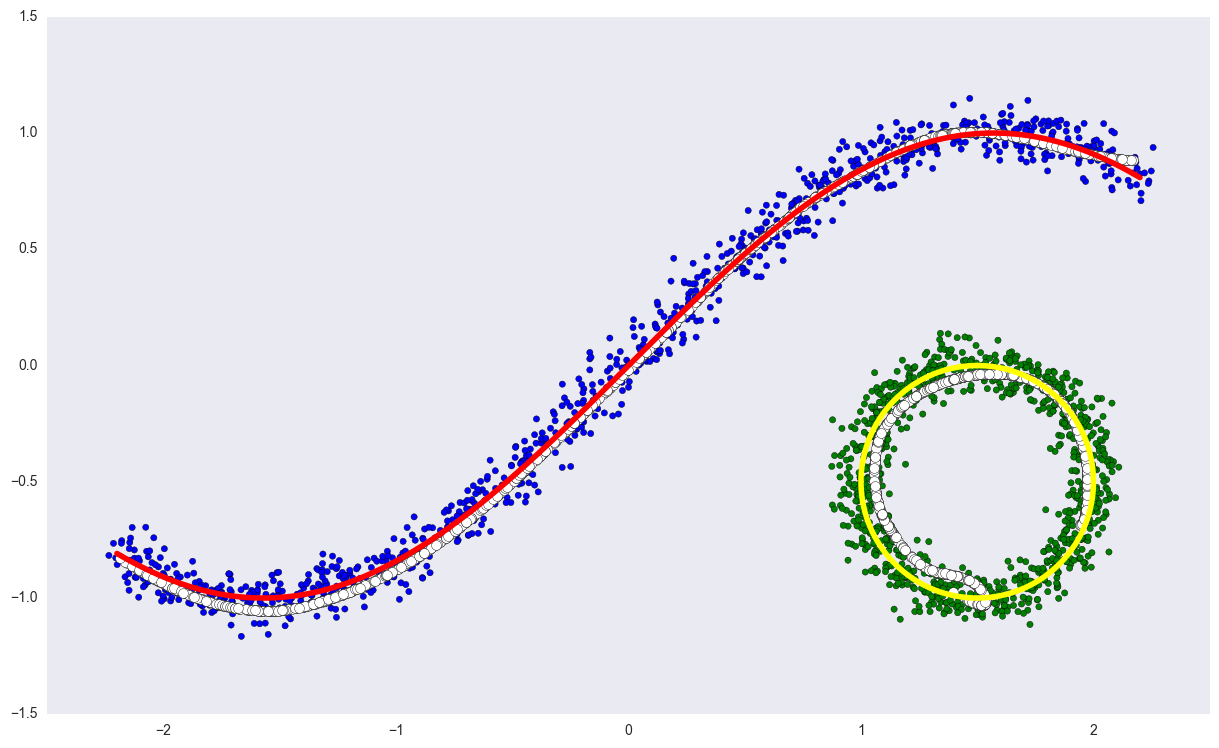

In [2]:
from keras.layers import concatenate


def deep_cond_ae():
    input_dots = Input((2,))
    input_lbls = Input((1,))
    full_input = concatenate([input_dots, input_lbls])
    x = Dense(64, activation='elu')(full_input)
    x = Dense(64, activation='elu')(x)
    code = Dense(1, activation='linear')(x)

    full_code = concatenate([code, input_lbls])
    x = Dense(64, activation='elu')(full_code)
    x = Dense(64, activation='elu')(x)
    out = Dense(2, activation='linear')(x)

    ae = Model([input_dots, input_lbls], out)
    return ae

cdae = deep_cond_ae()
cdae.compile(Adam(0.001), 'mse')
cdae.fit([noised, labels], noised, epochs=300, batch_size=30, verbose=2)


predicted = cdae.predict([noised, labels])
# Визуализация
plt.figure(figsize=(15, 9))
plt.xlim([-2.5, 2.5])
plt.ylim([-1.5, 1.5])
plt.scatter(noised[:, 0], noised[:, 1], c=colors)
plt.plot(dots1[:, 0], dots1[:, 1],  color="red",    linewidth=4)
plt.plot(dots2[:, 0], dots2[:, 1],  color="yellow", linewidth=4)
plt.scatter(predicted[:, 0], predicted[:, 1], c='white', s=50)
plt.grid(False)

<img src="./figs4/disconnected_manifold_cdae.png" width="600"/>

На этот раз автоэнкодеру удалось выучить линейно несвязное определяющее многообразие.

## CVAE

Если же теперь взять *VAE* как в предыдущей части, и подавать на вход еще и лейблы, то получится ***Conditional Variational Autoencoder (CVAE)***. 

С картинками цифр получается вот так:

![](./figs4/cvae_diagram.svg)

Картинка выше из ***[2]***

При этом основное уравнение *VAE* из прошлой части, становится просто *conditioned* на $Y$ ($Y$ при этом не обязан быть дискретным), то есть на лейбле.

$$
\log P(X|Y;\theta_2) - KL[Q(Z|X,Y;\theta_1)||P(Z|X,Y;\theta_2)] = E_{Z \sim Q}[\log P(X|Z,Y;\theta_2)] - KL[Q(Z|X,Y;\theta_1)||N(0,I)]
$$

$Q(Z|X,Y;\theta_1)$ при этом мы опять сравниваем с $N(0,I)$, вынуждая автоэнкодер искать $Z$ независимо от $Y$. 

*CVAE* кодирует в $Z$ свойства входного сигнала общие для всех $Y$.

## Перенос стиля
(Комментарий: это не тоже самое, что перенос стиля в Prisme, там совсем другое)

Теперь становится понятно, как создавать новые картинки в стиле заданной:
1. обучаем *CVAE* на картинках с лейблами,
2. кодируем стиль заданной картинки в $Z$,
3. меняя лейблы $Y$ создаем из закодированного $Z$ новые картинки

## Код на *Keras*

Код практически идентичен коду из предыдущей части, за исключением, того что теперь в энкодер и декодер передается и лейбл цифры.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns

from keras.datasets import mnist
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)
num_classes = y_test_cat.shape[1]

Using TensorFlow backend.


In [2]:
batch_size = 500
latent_dim = 2
dropout_rate = 0.3
start_lr = 0.001

In [3]:
from keras.layers import Input, Dense 
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda
from keras.layers import concatenate
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K


def create_cvae():
    models = {}

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x):
        return Dropout(dropout_rate)(BatchNormalization()(x))

    # Энкодер
    input_img = Input(shape=(28, 28, 1))
    flatten_img = Flatten()(input_img)
    input_lbl = Input(shape=(num_classes,), dtype='float32')

    x = concatenate([flatten_img, input_lbl])
    x = Dense(256, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model([input_img, input_lbl], l, 'Encoder') 
    models["z_meaner"] = Model([input_img, input_lbl], z_mean, 'Enc_z_mean')
    models["z_lvarer"] = Model([input_img, input_lbl], z_log_var, 'Enc_z_log_var')

    # Декодер
    z = Input(shape=(latent_dim, ))
    input_lbl_d = Input(shape=(num_classes,), dtype='float32')
    x = concatenate([z, input_lbl_d])
    x = Dense(256)(x)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    x = Dense(28*28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(x)

    models["decoder"] = Model([z, input_lbl_d], decoded, name='Decoder')
    models["cvae"]    = Model([input_img, input_lbl, input_lbl_d], 
                              models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), 
                              name="CVAE")
    models["style_t"] = Model([input_img, input_lbl, input_lbl_d], 
                               models["decoder"]([models["z_meaner"]([input_img, input_lbl]), input_lbl_d]), 
                               name="style_transfer")
    
    
    def vae_loss(x, decoded):
        x = K.reshape(x, shape=(batch_size, 28*28))
        decoded = K.reshape(decoded, shape=(batch_size, 28*28))
        xent_loss = 28*28*binary_crossentropy(x, decoded)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return (xent_loss + kl_loss)/2/28/28

    return models, vae_loss

models, vae_loss = create_cvae()
cvae = models["cvae"]

In [4]:
from keras.optimizers import Adam, RMSprop

cvae.compile(optimizer=Adam(start_lr), loss=vae_loss)

In [5]:
digit_size = 28

def plot_digits(*args, invert_colors=False):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors:
        figure = 1-figure

    plt.figure(figsize=(2*n, 2*len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()


n = 15 # Картинка с 15x15 цифр

from scipy.stats import norm
# Так как сэмплируем из N(0, I), то сетку узлов, в которых генерируем цифры берем из обратной функции распределения
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(generator, lbl, show=True):
    # Рисование цифр из многообразия
    figure = np.zeros((digit_size * n, digit_size * n))
    input_lbl = np.zeros((1, 10))
    input_lbl[0, lbl] = 1
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])

            x_decoded = generator.predict([z_sample, input_lbl])
            digit = x_decoded[0].squeeze()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    if show:
        # Визуализация
        plt.figure(figsize=(10, 10))
        plt.imshow(figure, cmap='Greys_r')
        plt.grid(False)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.show()
    return figure


def draw_z_distr(z_predicted, lbl):
    # Рисование рпспределения z
    input_lbl = np.zeros((1, 10))
    input_lbl[0, lbl] = 1
    im = plt.scatter(z_predicted[:, 0], z_predicted[:, 1])
    im.axes.set_xlim(-5, 5)
    im.axes.set_ylim(-5, 5)
    plt.show()

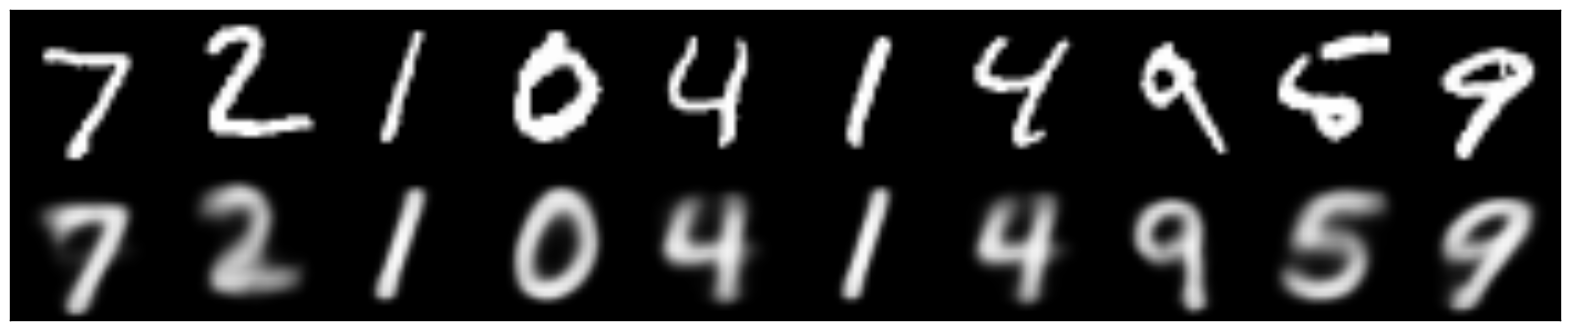

5


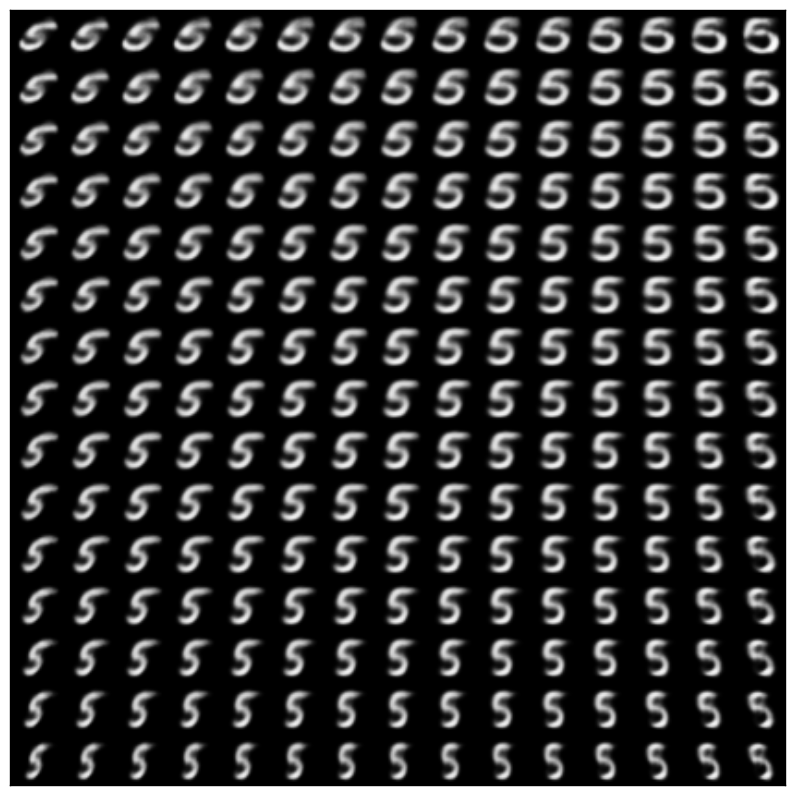

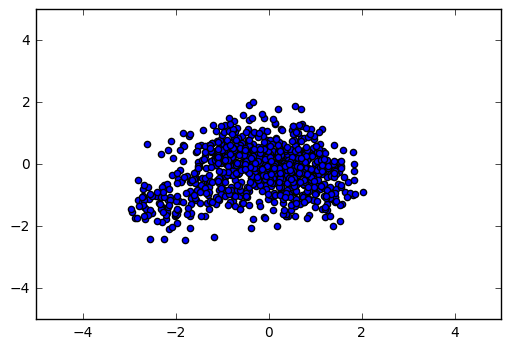

60000/60000 [==============================] - 4s - loss: 0.0916 - val_loss: 0.0879
Epoch 91/100
60000/60000 [==============================] - 1s - loss: 0.0917 - val_loss: 0.0879
Epoch 92/100
60000/60000 [==============================] - 1s - loss: 0.0916 - val_loss: 0.0880
Epoch 93/100
60000/60000 [==============================] - 1s - loss: 0.0916 - val_loss: 0.0879
Epoch 94/100
60000/60000 [==============================] - 1s - loss: 0.0916 - val_loss: 0.0879
Epoch 95/100
60000/60000 [==============================] - 1s - loss: 0.0916 - val_loss: 0.0879
Epoch 96/100
60000/60000 [==============================] - 1s - loss: 0.0915 - val_loss: 0.0878
Epoch 97/100
60000/60000 [==============================] - 1s - loss: 0.0915 - val_loss: 0.0878
Epoch 98/100
60000/60000 [==============================] - 1s - loss: 0.0915 - val_loss: 0.0880
Epoch 99/100
60000/60000 [==============================] - 1s - loss: 0.0915 - val_loss: 0.0878
Epoch 100/100
60000/60000 [================

In [6]:
from IPython.display import clear_output
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard

# Массивы в которые будем сохранять результаты для последующей визуализации
figs = [[] for x in range(num_classes)]
latent_distrs = [[] for x in range(num_classes)]
epochs = []

# Эпохи в которые будем сохранять
save_epochs = set(list((np.arange(0, 59)**1.701).astype(np.int)) + list(range(10)))

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]


# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

        # Рисование многообразия для рандомного y и распределения z|y
        draw_lbl = np.random.randint(0, num_classes)
        print(draw_lbl)
        for lbl in range(num_classes):
            figs[lbl].append(draw_manifold(generator, lbl, show=lbl==draw_lbl))
            idxs = y_test == lbl
            z_predicted = encoder_mean.predict([x_test[idxs], y_test_cat[idxs]], batch_size)
            latent_distrs[lbl].append(z_predicted)
            if lbl==draw_lbl:
                draw_z_distr(z_predicted, lbl)
        epochs.append(epoch)


# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
# lr_red = ReduceLROnPlateau(factor=0.1, patience=25)
tb     = TensorBoard(log_dir='./logs')


# Запуск обучения 
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=100,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig, tb],
         verbose=1)

## Результаты
(Извиняюсь, что местами белые цифры на черном фоне, а местами черные на белом)

Переводит цифры этот автоэнкодер вот так:
![](./figs4/map.png)

Сгенерированные цифры каждого лейбла сэмплированные из $N(0|I)$
<img src="./figs4/manifold_0.png" width="400"/>
<img src="./figs4/manifold_1.png" width="400"/>
<img src="./figs4/manifold_2.png" width="400"/>
<img src="./figs4/manifold_3.png" width="400"/>
<img src="./figs4/manifold_4.png" width="400"/>
<img src="./figs4/manifold_5.png" width="400"/>
<img src="./figs4/manifold_6.png" width="400"/>
<img src="./figs4/manifold_7.png" width="400"/>
<img src="./figs4/manifold_8.png" width="400"/>
<img src="./figs4/manifold_9.png" width="400"/>

### Генерация цифр заданного лейбла из $Z$ и распределение $Z$ для каждого лейбла (тяжелые гифки)

(скрыто)
<img src="./figs4/manifold_0.gif" width="500"/> <img src="./figs4/z_distr_0.gif" width="500"/> 
<img src="./figs4/manifold_1.gif" width="500"/> <img src="./figs4/z_distr_1.gif" width="500"/> 
<img src="./figs4/manifold_2.gif" width="500"/> <img src="./figs4/z_distr_2.gif" width="500"/> 
<img src="./figs4/manifold_3.gif" width="500"/> <img src="./figs4/z_distr_3.gif" width="500"/> 
<img src="./figs4/manifold_4.gif" width="500"/> <img src="./figs4/z_distr_4.gif" width="500"/> 
<img src="./figs4/manifold_5.gif" width="500"/> <img src="./figs4/z_distr_5.gif" width="500"/> 
<img src="./figs4/manifold_6.gif" width="500"/> <img src="./figs4/z_distr_6.gif" width="500"/> 
<img src="./figs4/manifold_7.gif" width="500"/> <img src="./figs4/z_distr_7.gif" width="500"/> 
<img src="./figs4/manifold_8.gif" width="500"/> <img src="./figs4/z_distr_8.gif" width="500"/> 
<img src="./figs4/manifold_9.gif" width="500"/> <img src="./figs4/z_distr_9.gif" width="500"/> 

### Перенос стиля этой моделью

В качестве источником стиля возьмем первые 10 нулей, и на основе их кода $Z$ создадим остальные цифры.

Код (скрыто):

In [7]:
def style_transfer(model, X, lbl_in, lbl_out):
    rows = X.shape[0]
    if isinstance(lbl_in, int):
        lbl = lbl_in
        lbl_in = np.zeros((rows, 10))
        lbl_in[:, lbl] = 1
    if isinstance(lbl_out, int):
        lbl = lbl_out
        lbl_out = np.zeros((rows, 10))
        lbl_out[:, lbl] = 1
    return model.predict([X, lbl_in, lbl_out])

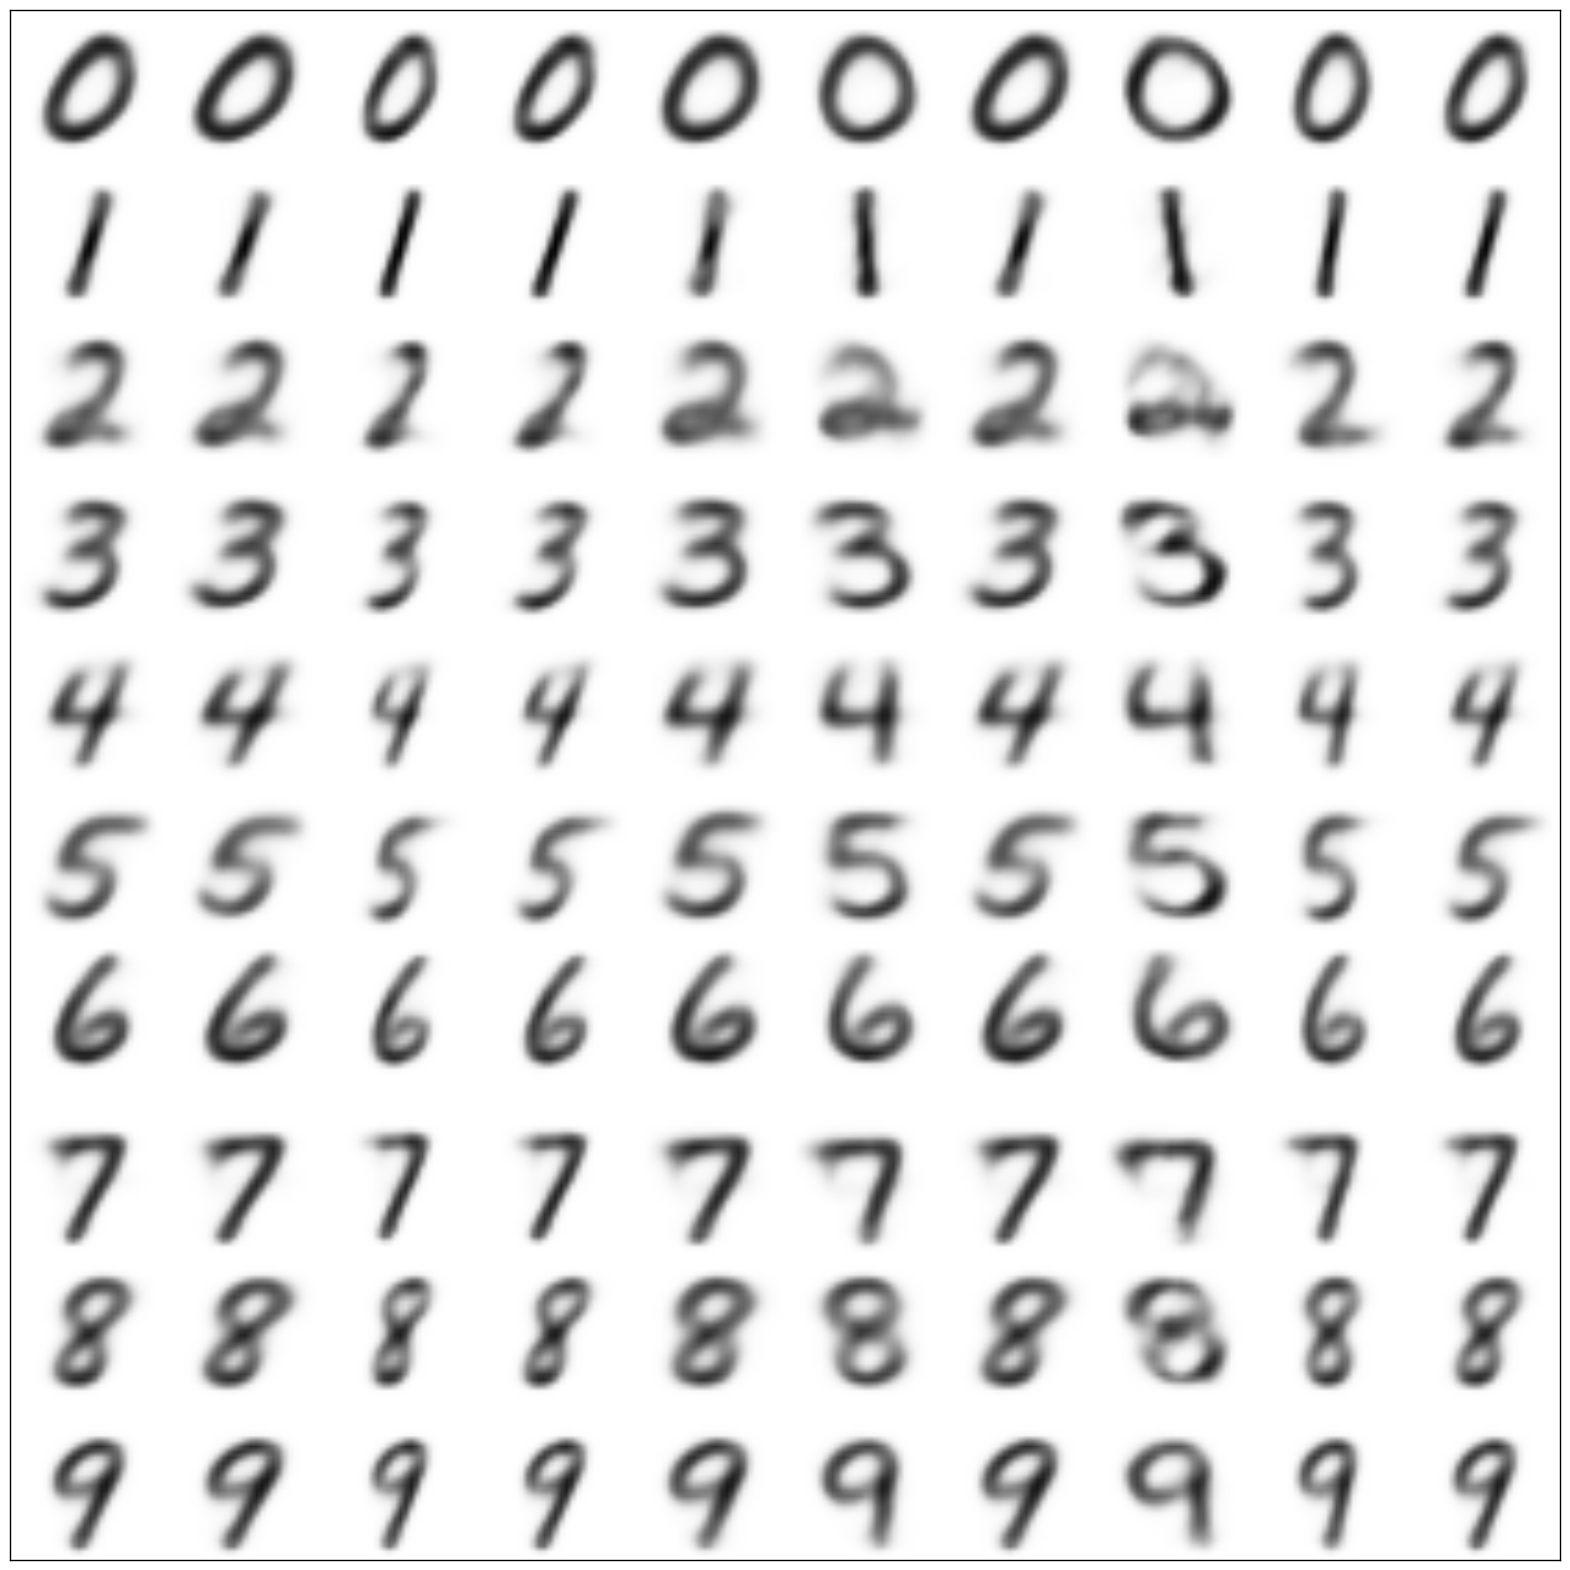

In [8]:
n = 10
lbl = 0
generated = []
prot = x_train[y_train == lbl][:n]

for i in range(num_classes):
    generated.append(style_transfer(models["style_t"], prot, lbl, i))

plot_digits(*generated, invert_colors=True)

<img src="./figs4/style_transfer.png" width="600"/>

Стиль перенесен довольно удачно: сохранен наклон и толщина штриха. Однако из-за того, что пространство $Z$ всего двумерное остальные свойства пропали: цифру семь, например, автоэнкодер рисует вообще без штриха. 

Больше свойств стиля можно было бы переносить просто увеличив размерность $Z$, это также сделало бы цифры менее размытыми.

В следующей части посмотрим, как используя *генеративные состязающиеся сети (GAN)*, научить автоэнкодер генерировать изображения практически неотличимые от настоящих.

### Код создания гифок 

C:\Users\Mikhail\Anaconda3\lib\site-packages\matplotlib\animation.py:784: UserWarning: MovieWriter imagemagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


OSError: Error saving animation to file (cause: [Errno 22] Invalid argument) Stdout: b'' StdError: b''. It may help to re-run with --verbose-debug.

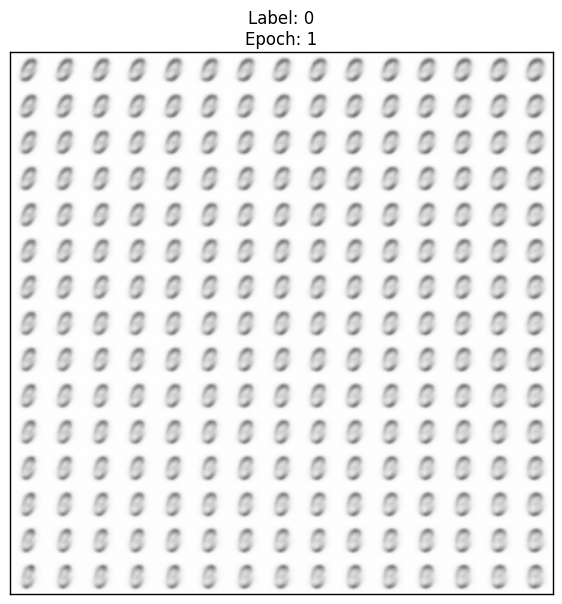

In [12]:
from matplotlib.animation import FuncAnimation
from matplotlib import cm
import matplotlib

def make_2d_figs_gif(figs, epochs, c, fname, fig): 
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False)
    im = plt.imshow(np.zeros((28,28)), cmap='Greys', norm=norm)
    plt.grid(None)
    plt.title("Label: {}\nEpoch: {}".format(c, epochs[0]))

    def update(i):
        im.set_array(figs[i])
        im.axes.set_title("Label: {}\nEpoch: {}".format(c, epochs[i]))
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        return im
    
    anim = FuncAnimation(fig, update, frames=range(len(figs)), interval=100)
    anim.save(fname, dpi=80, writer='imagemagick')

def make_2d_scatter_gif(zs, epochs, c, fname, fig):
    im = plt.scatter(zs[0][:, 0], zs[0][:, 1])
    plt.title("Label: {}\nEpoch: {}".format(c, epochs[0]))

    def update(i):
        fig.clear()
        im = plt.scatter(zs[i][:, 0], zs[i][:, 1])
        im.axes.set_title("Label: {}\nEpoch: {}".format(c, epochs[i]))
        im.axes.set_xlim(-5, 5)
        im.axes.set_ylim(-5, 5)
        return im

    anim = FuncAnimation(fig, update, frames=range(len(zs)), interval=100)
    anim.save(fname, dpi=80, writer='imagemagick')

for lbl in range(num_classes):
    make_2d_figs_gif(figs[lbl], epochs, lbl, "./figs4/manifold_{}.gif".format(lbl), plt.figure(figsize=(7,7)))
    make_2d_scatter_gif(latent_distrs[lbl], epochs, lbl, "./figs4/z_distr_{}.gif".format(lbl), plt.figure(figsize=(7,7)))

## Полезные ссылки и литература

Теоретическая часть основана на статье:  
[1] Tutorial on Variational Autoencoders, Carl Doersch, https://arxiv.org/abs/1606.05908  
и фактически является ее кратким изложением

Многие картинки взяты из блога Isaac Dykeman:  
[2] Isaac Dykeman, http://ijdykeman.github.io/ml/2016/12/21/cvae.html  

Подробнее прочитать про расстояние Кульбака-Лейблера на русском можно в   
[3] http://www.machinelearning.ru/wiki/images/d/d0/BMMO11_6.pdf  

Код частично основан на статье *Francois Chollet*:  
[4] https://blog.keras.io/building-autoencoders-in-keras.html  

Другие интересные ссылки:  
http://blog.fastforwardlabs.com/2016/08/12/introducing-variational-autoencoders-in-prose-and.html  
http://kvfrans.com/variational-autoencoders-explained/  
